In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt

from pathlib import Path

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [4]:
data_dir = Path('../color_captcha_preprocessed/')

# Get list of all the images
images = sorted(list(map(str, list(data_dir.glob('*.jpg')))))
print(images[:10])
labels = [img.split(os.path.sep)[-1].split('.jpg')[0] for img in images]
print(labels[:10])
characters = set(char for label in labels for char in label)
characters = sorted(list(characters))

print('Number of images found: ', len(images))
print('Number of labels found: ', len(labels))
print('Number of unique characters: ', len(characters))
print('Characters present: ', characters)

# Batch size for training and validation
batch_size = 16

# Desired image dimensions
img_width = 200
img_height = 50
downsample_factor = 4

# Maximum length of any captcha in the dataset
max_length = max([len(label) for label in labels])
# max_length = 4

['..\\color_captcha_preprocessed\\111J8.jpg', '..\\color_captcha_preprocessed\\111XM.jpg', '..\\color_captcha_preprocessed\\113DK.jpg', '..\\color_captcha_preprocessed\\113EV.jpg', '..\\color_captcha_preprocessed\\113SB.jpg', '..\\color_captcha_preprocessed\\114TY.jpg', '..\\color_captcha_preprocessed\\115RB.jpg', '..\\color_captcha_preprocessed\\116GW.jpg', '..\\color_captcha_preprocessed\\116OC.jpg', '..\\color_captcha_preprocessed\\119BG.jpg']
['111J8', '111XM', '113DK', '113EV', '113SB', '114TY', '115RB', '116GW', '116OC', '119BG']
Number of images found:  113062
Number of labels found:  113062
Number of unique characters:  35
Characters present:  ['1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']


In [5]:
# Mapping characters to integers
char_to_num = layers.StringLookup(vocabulary=list(characters), mask_token=None)

# Mapping integers back to original characters
num_to_char = layers.StringLookup(vocabulary=char_to_num.get_vocabulary(), mask_token=None, invert=True)


def split_data(images, labels, train_size=0.9, shuffle=True):
    # 1. Get the total size of the dataset and shuffle
    size = len(images)
    indices = np.arange(size)
    if shuffle: np.random.shuffle(indices)
    
    # Get the size and split data
    train_samples = int(size * train_size)
    x_train, y_train = images[indices[:train_samples]], labels[indices[:train_samples]]
    x_valid, y_valid = images[indices[train_samples:]], labels[indices[train_samples:]]
    return x_train, x_valid, y_train, y_valid


# Splitting data into training and validation sets
x_train, x_valid, y_train, y_valid = split_data(np.array(images), np.array(labels))


def encode_sample(img_path, label):
    # Read and decode image to grey scale
    img = tf.io.read_file(img_path)
    img = tf.io.decode_png(img, channels=1)
    
    # Convert to float32 in [0, 1] range (normalize)
    img = tf.image.convert_image_dtype(img, tf.float32)
    
    # Resize and transpose to the desired size
    img = tf.image.resize(img, [img_height, img_width])
    img = tf.transpose(img, perm=[1, 0, 2])
    
    # Map characters in label to numbers
    label = char_to_num(tf.strings.unicode_split(label, input_encoding="UTF-8"))
    
    # Return a dict as our model expects two inputs
    return {"image": img, "label": label}

In [6]:
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_dataset = (
    train_dataset.map(encode_sample, num_parallel_calls=tf.data.AUTOTUNE)
    .batch(batch_size)
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)

validation_dataset = tf.data.Dataset.from_tensor_slices((x_valid, y_valid))
validation_dataset = (
    validation_dataset.map(encode_sample, num_parallel_calls=tf.data.AUTOTUNE)
    .batch(batch_size)
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)

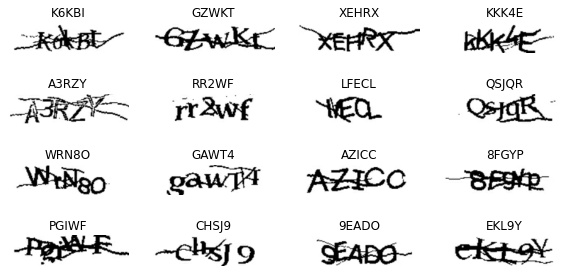

In [8]:
_, ax = plt.subplots(4, 4, figsize=(10, 5))
for batch in train_dataset.take(1):
    images = batch['image']
    labels = batch['label']
    for i in range(16):
        img = (images[i] * 255).numpy().astype('uint8')
        label = tf.strings.reduce_join(num_to_char(labels[i])).numpy().decode('utf-8')
        ax[i // 4, i % 4].imshow(img[:, :, 0].T, cmap='gray')
        ax[i // 4, i % 4].set_title(label)
        ax[i // 4, i % 4].axis('off')
plt.show()

In [6]:
# class Cust_CTCLayer(layers.Layer):
#     def __init__(self, name=None):
#         super().__init__(name=name)
#         self.loss_fn = keras.backend.ctc_batch_cost

#     def call(self, y_true, y_pred):
#         # Compute the training-time loss value and add it to the layer using self.add_loss().
#         batch_len = tf.cast(tf.shape(y_true)[0], dtype='int64')
#         input_length = tf.cast(tf.shape(y_pred)[1], dtype='int64')
#         label_length = tf.cast(tf.shape(y_true)[1], dtype='int64')

#         input_length = input_length * tf.ones(shape=(batch_len, 1), dtype='int64')
#         label_length = label_length * tf.ones(shape=(batch_len, 1), dtype='int64')

#         loss = self.loss_fn(y_true, y_pred, input_length, label_length)
#         self.add_loss(loss)
#         return y_pred


# def build_model():
#     # Inputs to the model
#     input_img = layers.Input(shape=(img_width, img_height, 1), name='image', dtype='float32')
#     labels = layers.Input(name='label', shape=(None,), dtype='float32')

#     # First conv block
#     x = layers.Conv2D(
#         32,
#         (3, 3),
#         activation='relu',
#         kernel_initializer='he_normal',
#         padding='same',
#         name='Conv1',
#     )(input_img)
    
#     x = layers.MaxPooling2D((2, 2), name='pool1')(x)

#     # Second conv block
#     x = layers.Conv2D(
#         64,
#         (3, 3),
#         activation='relu',
#         kernel_initializer='he_normal',
#         padding='same',
#         name='Conv2',
#     )(x)
#     x = layers.MaxPooling2D((2, 2), name='pool2')(x)

#     # two max pool with pool to downsample feature 4x smaller. The number of filters in the last layer is 64.
#     new_shape = ((img_width // 4), (img_height // 4) * 64)
#     x = layers.Reshape(target_shape=new_shape, name='reshape')(x)
#     x = layers.Dense(64, activation='relu', name='dense1')(x)
#     x = layers.Dropout(0.2)(x)

#     # RNNs
#     x = layers.Bidirectional(layers.LSTM(128, return_sequences=True, dropout=0.25))(x)
#     x = layers.Bidirectional(layers.LSTM(64, return_sequences=True, dropout=0.25))(x)

#     # Output layer
#     x = layers.Dense(len(char_to_num.get_vocabulary()) + 1, activation='softmax', name='dense2')(x)

#     # Add CTC layer for calculating CTC loss at each step
#     output = Cust_CTCLayer(name='ctc_loss')(labels, x)

#     # Define the model
#     model = keras.models.Model(inputs=[input_img, labels], outputs=output, name='ocr_model_v2')
#     opt = keras.optimizers.Adam()
#     model.compile(optimizer=opt)
#     return model


# model = build_model()
# model.summary()

Model: "ocr_model_v1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 image (InputLayer)             [(None, 200, 50, 1)  0           []                               
                                ]                                                                 
                                                                                                  
 Conv1 (Conv2D)                 (None, 200, 50, 32)  320         ['image[0][0]']                  
                                                                                                  
 pool1 (MaxPooling2D)           (None, 100, 25, 32)  0           ['Conv1[0][0]']                  
                                                                                                  
 Conv2 (Conv2D)                 (None, 100, 25, 64)  18496       ['pool1[0][0]']       

In [10]:
# epochs = 23
# early_stopping_patience = 10
# # Add early stopping
# early_stopping = keras.callbacks.EarlyStopping(monitor="val_loss", patience=early_stopping_patience, restore_best_weights=True)

# # Train the model
# history = model.fit(
#     train_dataset,
#     validation_data=validation_dataset,
#     epochs=epochs,
#     callbacks=[early_stopping],
# )

# if not os.path.isdir('./saved_model'): 
#     os.mkdir('./saved_model')
# model.save('saved_model/colored_model2')

Epoch 1/23
6360/6360 [==============================] - 914s 144ms/step - loss: 5.9633 - val_loss: 2.7162
Epoch 2/23
6360/6360 [==============================] - 893s 140ms/step - loss: 2.8777 - val_loss: 1.6047
Epoch 3/23
6360/6360 [==============================] - 886s 139ms/step - loss: 2.1712 - val_loss: 1.3675
Epoch 4/23
6360/6360 [==============================] - 904s 142ms/step - loss: 1.8719 - val_loss: 1.1978
Epoch 5/23
6360/6360 [==============================] - 913s 144ms/step - loss: 1.6628 - val_loss: 1.0009
Epoch 6/23
6360/6360 [==============================] - 908s 143ms/step - loss: 1.5436 - val_loss: 0.9794
Epoch 7/23
6360/6360 [==============================] - 932s 147ms/step - loss: 1.4588 - val_loss: 0.9480
Epoch 8/23
6360/6360 [==============================] - 964s 152ms/step - loss: 1.3741 - val_loss: 0.8570
Epoch 9/23
6360/6360 [==============================] - 990s 156ms/step - loss: 1.3193 - val_loss: 0.9352
Epoch 10/23
6360/6360 [=======================

INFO:tensorflow:Assets written to: saved_model/colored_model2\assets


INFO:tensorflow:Assets written to: saved_model/colored_model2\assets


In [7]:
# model = keras.models.load_model('../notebooks/saved_model/colored_model2/')

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 image (InputLayer)          [(None, 200, 50, 1)]      0         
                                                                 
 Conv1 (Conv2D)              (None, 200, 50, 32)       320       
                                                                 
 pool1 (MaxPooling2D)        (None, 100, 25, 32)       0         
                                                                 
 Conv2 (Conv2D)              (None, 100, 25, 64)       18496     
                                                                 
 pool2 (MaxPooling2D)        (None, 50, 12, 64)        0         
                                                                 
 reshape (Reshape)           (None, 50, 768)           0         
                                                                 
 dense1 (Dense)              (None, 50, 64)            4921

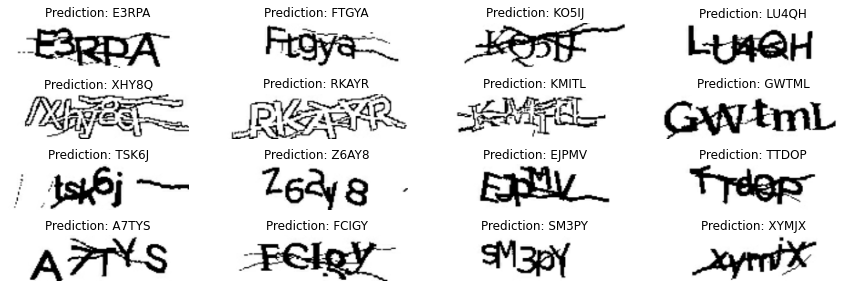

In [9]:
# Get the prediction model by extracting layers till the output layer
prediction_model = keras.models.Model(model.get_layer(name='image').input, model.get_layer(name='dense2').output)
prediction_model.summary()

# function to decode the output of the network
def decode_batch_predictions(pred):
    input_len = np.ones(pred.shape[0]) * pred.shape[1]
    results = keras.backend.ctc_decode(pred, input_length=input_len, greedy=False)[0][0][:, :max_length]

    output_text = []
    for res in results:
        res = tf.strings.reduce_join(num_to_char(res)).numpy().decode('utf-8')
        output_text.append(res)
    return output_text


#  check results on some validation samples
for batch in validation_dataset.take(1):
    batch_images = batch['image']
    batch_labels = batch['label']

    preds = prediction_model.predict(batch_images)
    pred_texts = decode_batch_predictions(preds)

    orig_texts = []
    for label in batch_labels:
        label = tf.strings.reduce_join(num_to_char(label)).numpy().decode('utf-8')
        orig_texts.append(label)

    _, ax = plt.subplots(4, 4, figsize=(15, 5))
    for i in range(len(pred_texts)):
        img = (batch_images[i, :, :, 0] * 255).numpy().astype(np.uint8)
        img = img.T
        title = f"Prediction: {pred_texts[i]}"
        ax[i // 4, i % 4].imshow(img, cmap='gray')
        ax[i // 4, i % 4].set_title(title)
        ax[i // 4, i % 4].axis('off')
plt.show()

In [10]:
data_dir = Path('../vtop_captcha_preprocessed/sub_dir_to_make_keras_happy/')

# Get list of all the images
images = sorted(list(map(str, list(data_dir.glob("*.png")))))
print(images[:10])
labels = [img.split(os.path.sep)[-1].split(".png")[0] for img in images]
print(labels[:10])
characters = set(char for label in labels for char in label)
characters = sorted(list(characters))

print('Number of images found: ', len(images))
print('Number of labels found: ', len(labels))
print('Number of unique characters: ', len(characters))
print('Characters present: ', characters)


# Desired image dimensions
img_width = 200
img_height = 50
downsample_factor = 4

# Maximum length of any captcha in the dataset
max_length = max([len(label) for label in labels])

['..\\vtop_captcha_preprocessed\\sub_dir_to_make_keras_happy\\276WTL.png', '..\\vtop_captcha_preprocessed\\sub_dir_to_make_keras_happy\\3375MC.png', '..\\vtop_captcha_preprocessed\\sub_dir_to_make_keras_happy\\3GYNI7.png', '..\\vtop_captcha_preprocessed\\sub_dir_to_make_keras_happy\\53VG1C.png', '..\\vtop_captcha_preprocessed\\sub_dir_to_make_keras_happy\\6KSG5M.png', '..\\vtop_captcha_preprocessed\\sub_dir_to_make_keras_happy\\74NQT8.png', '..\\vtop_captcha_preprocessed\\sub_dir_to_make_keras_happy\\B1DY3V.png', '..\\vtop_captcha_preprocessed\\sub_dir_to_make_keras_happy\\CRDIJ2.png', '..\\vtop_captcha_preprocessed\\sub_dir_to_make_keras_happy\\CU3NAV.png', '..\\vtop_captcha_preprocessed\\sub_dir_to_make_keras_happy\\D5DHAQ.png']
['276WTL', '3375MC', '3GYNI7', '53VG1C', '6KSG5M', '74NQT8', 'B1DY3V', 'CRDIJ2', 'CU3NAV', 'D5DHAQ']
Number of images found:  30
Number of labels found:  30
Number of unique characters:  34
Characters present:  ['1', '2', '3', '4', '5', '6', '7', '8', '9', 'A

In [ ]:
# from tensorflow.keras.preprocessing import image_dataset_from_directory

In [11]:
# Mapping characters to integers
char_to_num = layers.StringLookup(vocabulary=list(characters), mask_token=None)

# Mapping integers back to original characters
num_to_char = layers.StringLookup(vocabulary=char_to_num.get_vocabulary(), mask_token=None, invert=True)

In [12]:
test_dataset = tf.data.Dataset.from_tensor_slices((np.array(images), np.array(labels)))
test_dataset = (
    test_dataset.map(encode_sample, num_parallel_calls=tf.data.AUTOTUNE)
    .batch(16)
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)

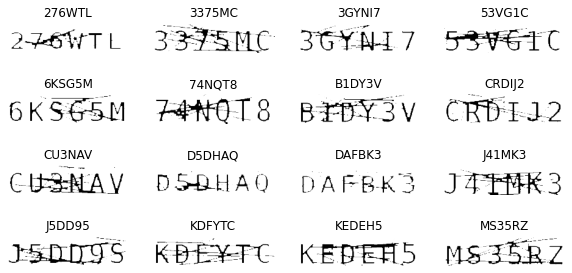

In [8]:
_, ax = plt.subplots(4, 4, figsize=(10, 5))
for batch in test_dataset.take(1):
    images = batch['image']
    labels = batch['label']
    for i in range(16):
        img = (images[i] * 255).numpy().astype('uint8')
        label = tf.strings.reduce_join(num_to_char(labels[i])).numpy().decode('utf-8')
        ax[i // 4, i % 4].imshow(img[:, :, 0].T, cmap='gray')
        ax[i // 4, i % 4].set_title(label)
        ax[i // 4, i % 4].axis('off')
plt.show()

1/1 [==============================] - 0s 56ms/step


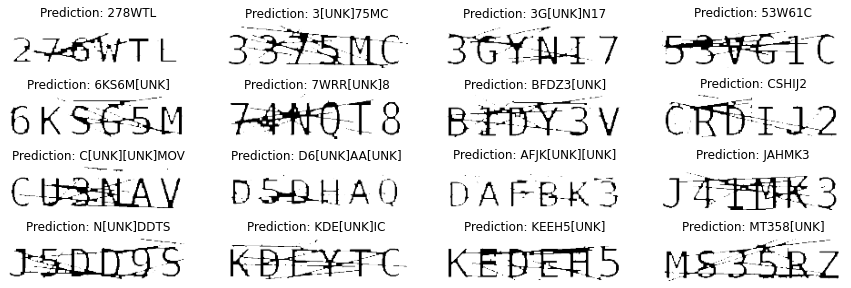

In [15]:
#  check results on some validation samples
for batch in test_dataset.take(1):
    batch_images = batch['image']
    batch_labels = batch['label']

    preds = prediction_model.predict(batch_images)
    pred_texts = decode_batch_predictions(preds)

    orig_texts = []
    for label in batch_labels:
        label = tf.strings.reduce_join(num_to_char(label)).numpy().decode('utf-8')
        orig_texts.append(label)

    _, ax = plt.subplots(4, 4, figsize=(15, 5))
    for i in range(len(pred_texts)):
        img = (batch_images[i, :, :, 0] * 255).numpy().astype(np.uint8)
        img = img.T
        title = f'Prediction: {pred_texts[i]}'
        ax[i // 4, i % 4].imshow(img, cmap='gray')
        ax[i // 4, i % 4].set_title(title)
        ax[i // 4, i % 4].axis('off')
plt.show()